# After running run_many.py this notebook will reproduce Fig. 4 of 2508.21131

### - Start with imports

In [1]:
# Global imports
import sys
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.stats import chi2

sys.path.append("../")

# Local imports
import examples_utils as eu
from fastPTA.angular_decomposition import spherical_harmonics as sph

print(eu.path_to_file)
%reload_ext autoreload
%autoreload 2

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 14,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

cmap = plt.get_cmap("Reds")

/home/pieroni/my_projects/fastPTA_papers/paper_cosmic_variance/fastpta_anisotropies/examples/examples_paper_cosmic_variance/..


### - Define some constants 

In [2]:
# number of realizations (should match the datafile)
N_runs = 1000

# number of data points generated for each realization
N_data = 100

# whether we used the dipole in the analysis or not
add_dipole = False

# if ff is present
ff_integral = True

path = "generated_data/"
if ff_integral:
    path += "ff_"
if add_dipole:
    path += "dipole_"

output = "plots/"
if ff_integral:
    output += "ff_"
if add_dipole:
    output += "dipole_"

print("Path:", path)
print("Output:", output)

# Number of pulsars used in the analysis diagonal f analysis
n_pulsars1 = ["70", "120", "200", "500"]

# Number of pulsars used in the ff analysis
n_pulsars2 = ["70", "120", "200", "500"]

if ff_integral:
    n_pulsars = n_pulsars2
else:
    n_pulsars = n_pulsars1

# Colors for the plot, add more if n_pulsars1/n_pulsars2 have more elements
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

Path: generated_data/ff_
Output: plots/ff_


### - Angular part (should match the injection used in the run)

In [3]:
# Would be nice to update it to read it from the data
l_max = 3

injection = np.zeros(sph.get_n_coefficients_real(l_max))

injection[0] = 1.0

if add_dipole:
    injection[2] = 1.0 / np.sqrt(3)

# Normalize the clms
injection /= np.sqrt(4 * np.pi)

### - Get the CLs 

In [ ]:
# Compute the angular power spectrum
CL = np.zeros((len(n_pulsars), l_max + 1, N_runs))

# Keep the length of the filtered data
len_data = []

for k in tqdm.tqdm(range(len(n_pulsars))):

    # Load the data for the current number of runs
    data = np.load(path + str(N_runs) + "_" + n_pulsars[k] + "_12_15.npz")

    # get the means and standard deviations of the clms
    clms = data["means"]

    # filter out NaN values
    clms = clms[~np.isnan(clms).any(axis=1)]

    # subtract the mean from the monopole
    clms[:, 0] -= injection[0]

    # check the len of the filtered data
    N_d = len(clms)

    # store the len
    len_data.append(N_d)

    # Store the CLs
    CL[k, :, :N_d] = sph.get_CL_from_real_clm(clms.T)

100%|██████████| 4/4 [00:00<00:00, 1454.34it/s]


### - Plot them all

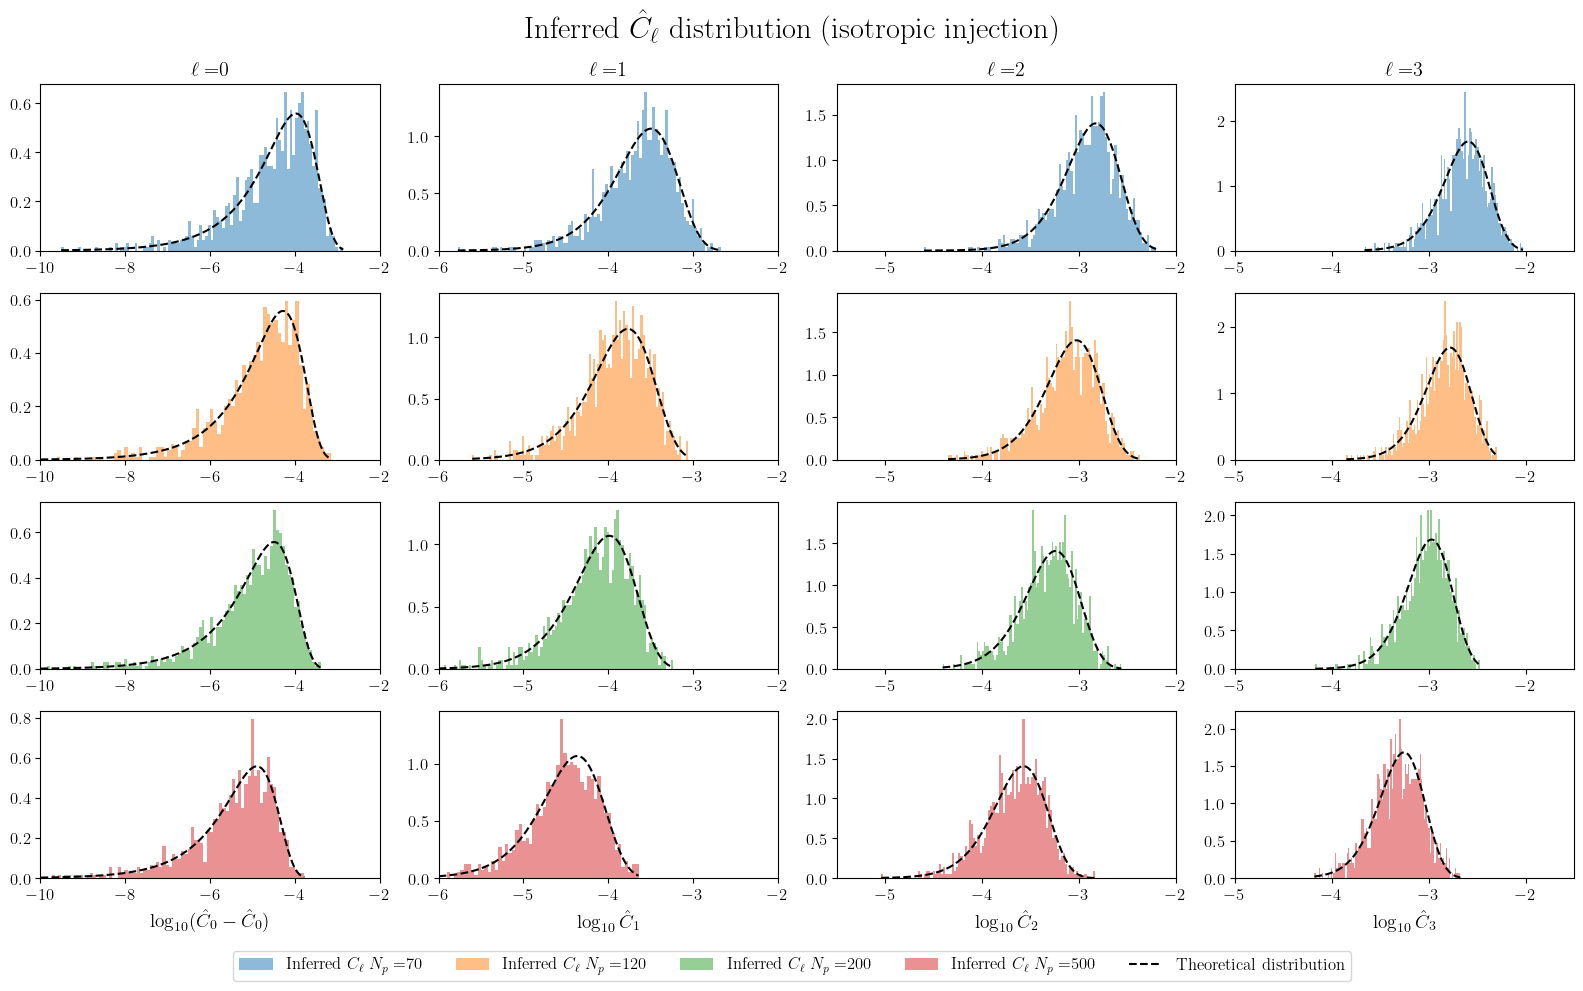

In [ ]:
n_bins = 100

fig, ax = plt.subplots(ncols=4, nrows=len(n_pulsars), figsize=(16, 10))

th_dist = lambda x, Ns, Cl: (Ns / Cl) * chi2.pdf(Ns * x / Cl, df=Ns)


for k in range(len(n_pulsars)):
    for i in range(0, l_max + 1):
        x, b, _ = ax[k, i].hist(
            np.log10(CL[k, i, : len_data[k]]),
            bins=n_bins,
            density=True,
            alpha=0.5,
            color=colors[k],
            label=r"Inferred $C_{\ell} \; N_p = $" + n_pulsars[k],
        )

        xx = np.linspace(b[0], b[-1], 10000)
        to_plot = 10**xx * th_dist(
            10**xx, 2 * i + 1, np.mean(CL[k, i, : len_data[k]])
        )
        normalization = simpson(to_plot, x=xx)
        ax[k, i].plot(
            xx,
            to_plot / normalization,
            color="black",
            linestyle="dashed",
            label="Theoretical distribution",
            zorder=+10,
        )
        if i == 0:
            ax[k, i].set_xlim(-10, -2)

        elif i == 1:
            ax[k, i].set_xlim(-6, -2)
        elif i == 2:
            ax[k, i].set_xlim(-5.5, -2)
        else:
            ax[k, i].set_xlim(-5, -1.5)

        if k == 0:
            ax[k, i].set_title(r"$\ell=$" + str(i))

        if k == len(n_pulsars) - 1 and i == 0:
            ax[k, i].set_xlabel(
                r"$\log_{10} (\hat{C}_{" + str(i) + "} - \hat{C}_{0})$"
            )

        elif k == len(n_pulsars) - 1:
            ax[k, i].set_xlabel(r"$\log_{10} \hat{C}_{" + str(i) + "}$")

handles, labels = ax[0, 0].get_legend_handles_labels()
hh = handles[-1:]
ll = labels[-1:]
handles = handles[:1]
labels = labels[:1]

for k in range(1, len(n_pulsars)):
    h, l = ax[k, 0].get_legend_handles_labels()
    handles.extend(h[:1])
    labels.extend(l[:1])

handles.extend(hh)
labels.extend(ll)

fig.suptitle(
    r"Inferred $\hat{C}_{\ell}$ distribution (isotropic injection)", fontsize=22
)
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=5,
    bbox_to_anchor=(0.5, 0.00),
    fontsize=12,
)
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("plots/all_CLs_stats.pdf", dpi=300)